# Bayesian Optimization
The objective of this notebook is to implement a simple sequential decision-making model using Bayesian Optimization and learn how to setup a [BoTorch](https://botorch.org/)) pipeline. 

The target function was copied over from another BayesOpt package: [fmfn/bayesianoptimization](https://github.com/fmfn/BayesianOptimization/blob/master/examples/visualization.ipynb).

The acquisition function used was UpperConfidenceBound:
$$UCB(x) = \mu(x) + \sqrt{\beta} * \sigma(x)$$

We will show two different models: one with $\beta=1$ (exploitation) and one with $\beta=25$ (exploration).

### Helpful Links:
- [Roman Garnett's Bayes Opt Notes](https://www.cse.wustl.edu/~garnett/cse515t/spring_2018/files/lecture_notes/13.pdf) 
- [GPyTorch Regression Tutorial
](https://docs.gpytorch.ai/en/v1.1.1/examples/01_Exact_GPs/Simple_GP_Regression.html)
- [Facebook AI blog post](https://ai.facebook.com/blog/open-sourcing-ax-and-botorch-new-ai-tools-for-adaptive-experimentation/)
- [BoTorch Docs](https://botorch.org/tutorials/)
- [SciKit based BayesOpt Package](https://github.com/fmfn/BayesianOptimization)
- [Practical Bayes Opt Paper](https://arxiv.org/pdf/1206.2944.pdf)

## Imports

In [1]:
import torch
import numpy as np
from tqdm import tqdm

from botorch.fit import fit_gpytorch_model
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf
from botorch.acquisition import ExpectedImprovement, UpperConfidenceBound


import matplotlib.pyplot as plt

%matplotlib inline

### Fit GP model to dataset
The following function (`get_model`) fits a Gaussian Process to a set of observations.

In [4]:
## build GP model
## initialize a GP with data
## use likelihood to find GP params
def get_model(train_x, train_y, state_dict=None, debug=False):
    gp  = SingleTaskGP(train_x, train_y)
    if debug:
        print("Prior hyperparams lengthscale & noise: {}, {}".format(gp.covar_module.base_kernel.lengthscale.item(), gp.likelihood.noise.item()))
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    if state_dict is not None:
        gp.load_state_dict(state_dict) # speeds up fit
    fit_gpytorch_model(mll) # performs the hyperparam fit
    if debug:
        print("Post hyperparams lengthscale & noise:  {}, {}".format(gp.covar_module.base_kernel.lengthscale.item(), gp.likelihood.noise.item()))
    return gp, mll

### Target Function
The function we would like to maximize.

In [5]:
def target(x):
    return torch.exp(-(x - 2)**2) + torch.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)

### Random Init 
Randomly sample search space to warm up Gaussian Process

In [7]:
# random start
train_x = torch.FloatTensor(4, 1).uniform_(-2., 10.)

# train_x   = torch.tensor([[3.109], [7.775]])
train_obj = target(train_x)
model, mll = get_model(train_x, train_obj, debug=True)

train_x_explore = torch.clone(train_x)
train_obj_explore = torch.clone(train_obj)
model_explore, mll_explore = get_model(train_x, train_obj, debug=True)

Prior hyperparams lengthscale & noise: 0.6931471824645996, 2.000000476837158
Post hyperparams lengthscale & noise:  0.49891459941864014, 0.0007681268616579473
Prior hyperparams lengthscale & noise: 0.6931471824645996, 2.000000476837158
Post hyperparams lengthscale & noise:  0.49891459941864014, 0.0007681268616579473


### Plot Target
We can see that the max is at $x \sim 2$.

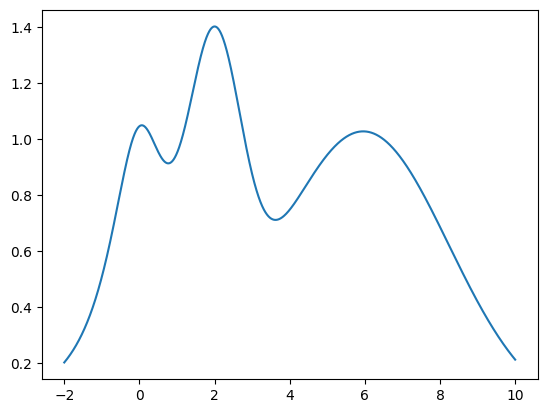

In [8]:
x = torch.linspace(-2, 10, 10000).reshape(-1, 1)
y = target(x)

plt.plot(x, y);

The following function finds the maximum of the Acquisition Function. (only used for plotting purposes)

In [24]:
def get_max(model,beta):
    UCB      = UpperConfidenceBound(model=model, beta=beta)
    new_point_analytic, acq_value_list = optimize_acqf(
                acq_function=UCB,
                bounds=torch.tensor([[-2.], [10.]]),
                q=1,  # number of candidates
                num_restarts=20,  # The number of starting points for multistart acquisition function optimization.
                raw_samples=100,  # The number of samples for initialization.
                options={},
                return_best_only=True,
                sequential=False  # If False, uses joint optimization, otherwise uses sequential optimization.
    )
    return new_point_analytic, acq_value_list

### One Step of Bayes Opt
`step` probes a single query point (chosen by the acquisition function) and updates the GP.

In [25]:
def step(model, mll, train_x, train_obj, beta=5.):
    # optimize acquisition function
    UCB      = UpperConfidenceBound(model=model, beta=beta)
    new_point_analytic, acq_value_list = optimize_acqf(
                acq_function=UCB,
                bounds=torch.tensor([[-2.], [10.]]),
                q=1,
                num_restarts=20,
                raw_samples=100,
                options={},
                return_best_only=True,
                sequential=False
    )
    smth      = target(new_point_analytic)
    train_obj = torch.cat([smth, train_obj])
    train_x   = torch.cat([new_point_analytic, train_x])

    model, mll = get_model(train_x, train_obj, model.state_dict())
    return model, mll, train_x, train_obj

### Plot mean prediction and uncertainty
Plots to compare the decision making of two different models.

In [26]:
def plot():
    with torch.no_grad():
        mean_preds = model(x).mean
        std_preds  = model(x).stddev
        lower, upper  = model(x).confidence_region()
        mean_preds_explore = model_explore(x).mean
        lower_explore, upper_explore = model_explore(x).confidence_region()
        std_preds_explore  = model_explore(x).stddev
        
    _argmax, _max = get_max(model, 1.) # max of acq function
    _argmax_explore, _max_explore = get_max(model_explore, 25.) # max of acq function
    acq = mean_preds + std_preds
    acq_explore = mean_preds_explore + 5.* std_preds_explore
    fix, ax = plt.subplots(2,2,sharey=True,figsize=(16,8))
    ax[0,0].set_title("Exploitation")
    ax[0,0].plot(x,mean_preds, label='mean')
    ax[0,0].plot(x,y, label='target')
    ax[0,0].fill_between(x.flatten(),lower, upper, alpha=0.5, label='uncertainty')
    ax[0,0].scatter(train_x, train_obj, label='observations')
    ax[0,0].legend()
    ax[1,0].set_title("Acquisition Function: $beta$=1")
    ax[1,0].plot(x,acq, label='UCB')
    ax[1,0].scatter(_argmax, _max,marker='d',color='r',label='Max')
    ax[0,1].set_title("Exploration")
    ax[0,1].plot(x,mean_preds_explore, label='mean')
    ax[0,1].plot(x,y, label='target')
    ax[0,1].fill_between(x.flatten(),lower_explore, upper_explore, alpha=0.5, label='uncertainty')
    ax[0,1].scatter(train_x_explore, train_obj_explore, label='observations')
    ax[1,1].set_title("Acquisition Function: $beta$=25")
    ax[1,1].plot(x,acq_explore,label='UCB')
    ax[1,1].scatter(_argmax_explore, _max_explore,marker='d',color='r',label='Max')
    ax[1,1].legend()

#### Initial Plot with 4 random observations

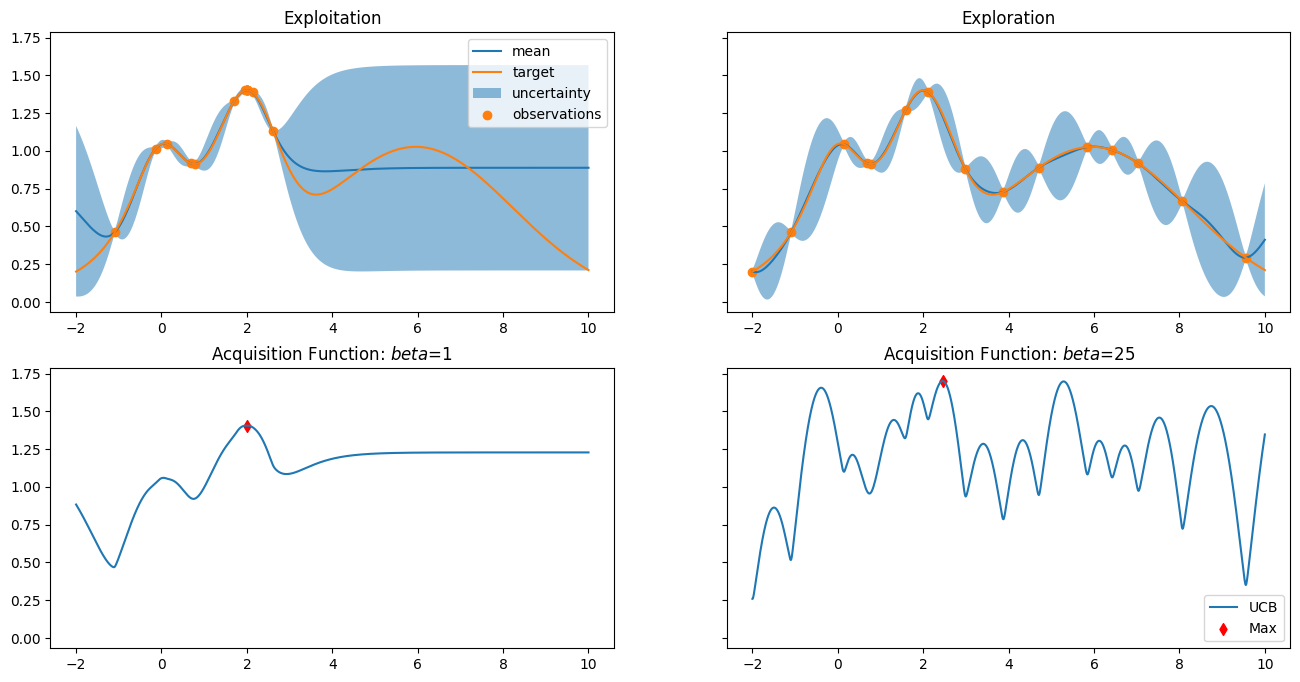

In [27]:
plot()

Prior hyperparams lengthscale & noise: 0.6931471824645996, 2.000000476837158
Post hyperparams lengthscale & noise:  0.6370874643325806, 0.00025208323495462537
Prior hyperparams lengthscale & noise: 0.6931471824645996, 2.000000476837158
Post hyperparams lengthscale & noise:  0.5155531764030457, 0.0010053126607090235


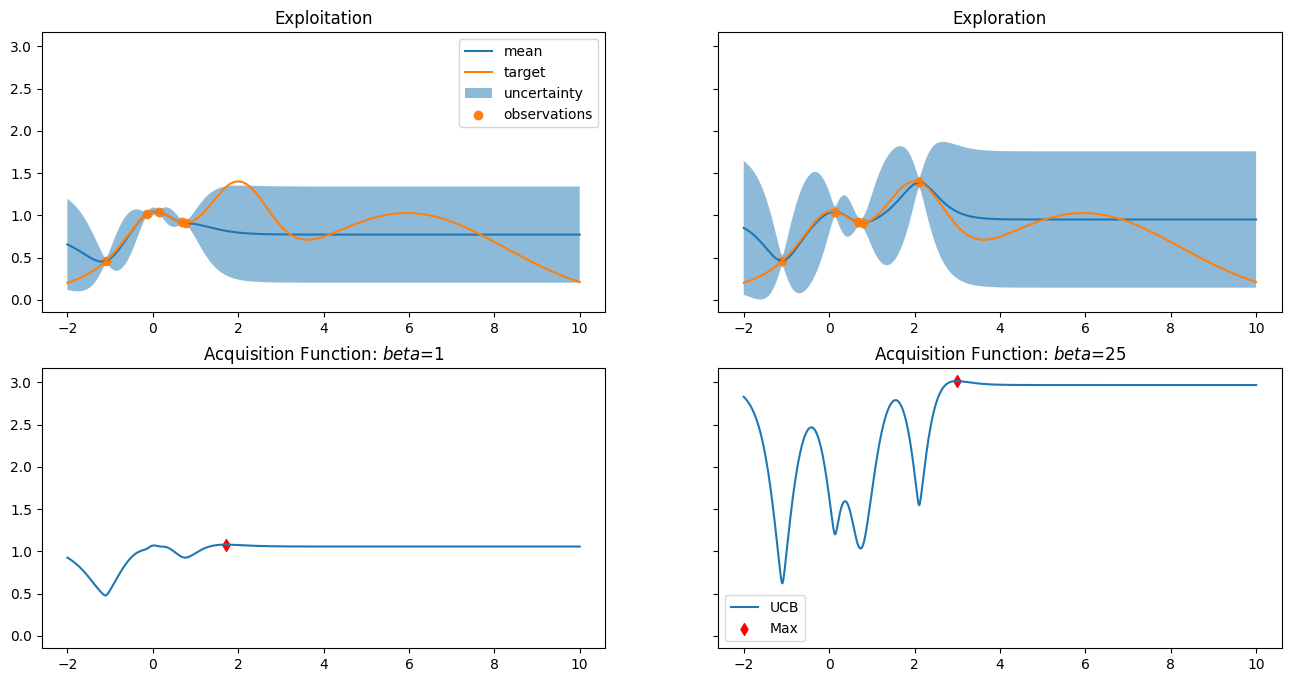

In [13]:
model, mll, train_x, train_obj = step(model, mll, train_x, train_obj, beta=1.)
model_explore, mll_explore, train_x_explore, train_obj_explore = step(model_explore, mll_explore, train_x_explore, train_obj_explore,beta=25.)
plot()

Prior hyperparams lengthscale & noise: 0.6931471824645996, 2.000000476837158
Post hyperparams lengthscale & noise:  0.6654772162437439, 0.0002797938068397343
Prior hyperparams lengthscale & noise: 0.6931471824645996, 2.000000476837158
Post hyperparams lengthscale & noise:  0.4762590229511261, 0.000936280470341444


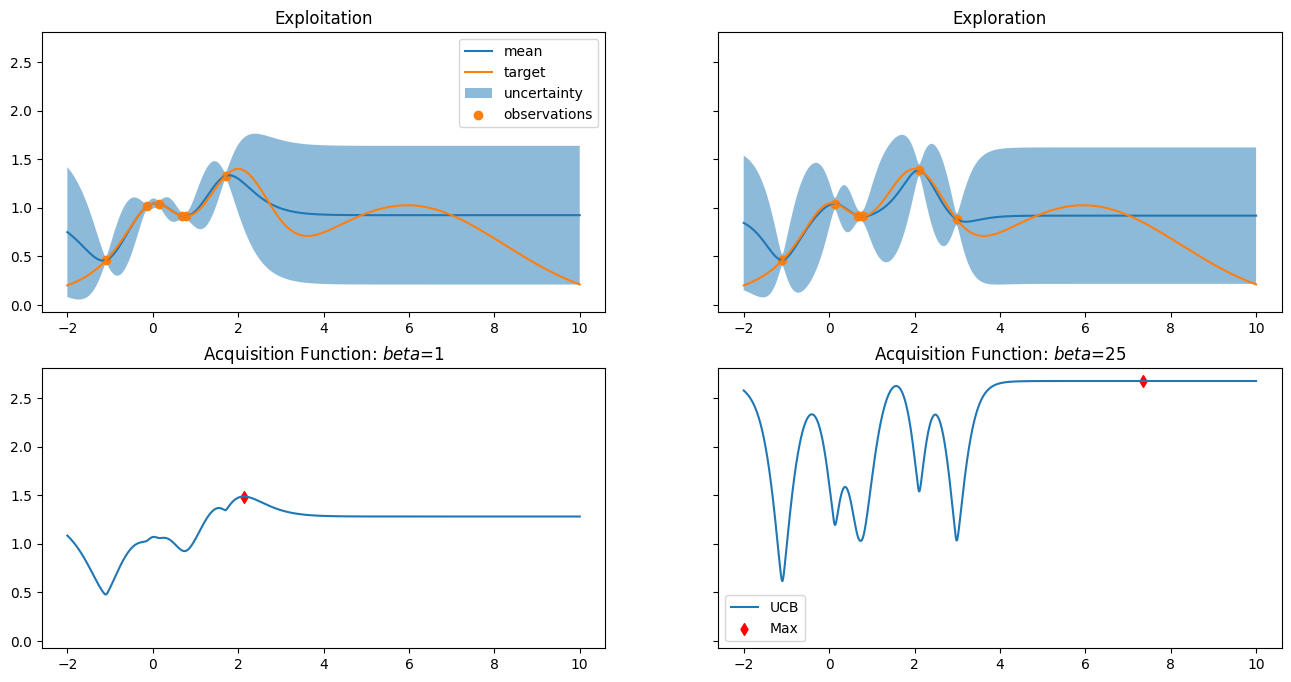

In [14]:
model, mll, train_x, train_obj = step(model, mll, train_x, train_obj, beta=1.)
model_explore, mll_explore, train_x_explore, train_obj_explore = step(model_explore, mll_explore, train_x_explore, train_obj_explore,beta=25.)
plot()

Prior hyperparams lengthscale & noise: 0.6931471824645996, 2.000000476837158
Post hyperparams lengthscale & noise:  0.7001138925552368, 0.0002114803937729448
Prior hyperparams lengthscale & noise: 0.6931471824645996, 2.000000476837158
Post hyperparams lengthscale & noise:  0.5431950688362122, 0.000910004717297852


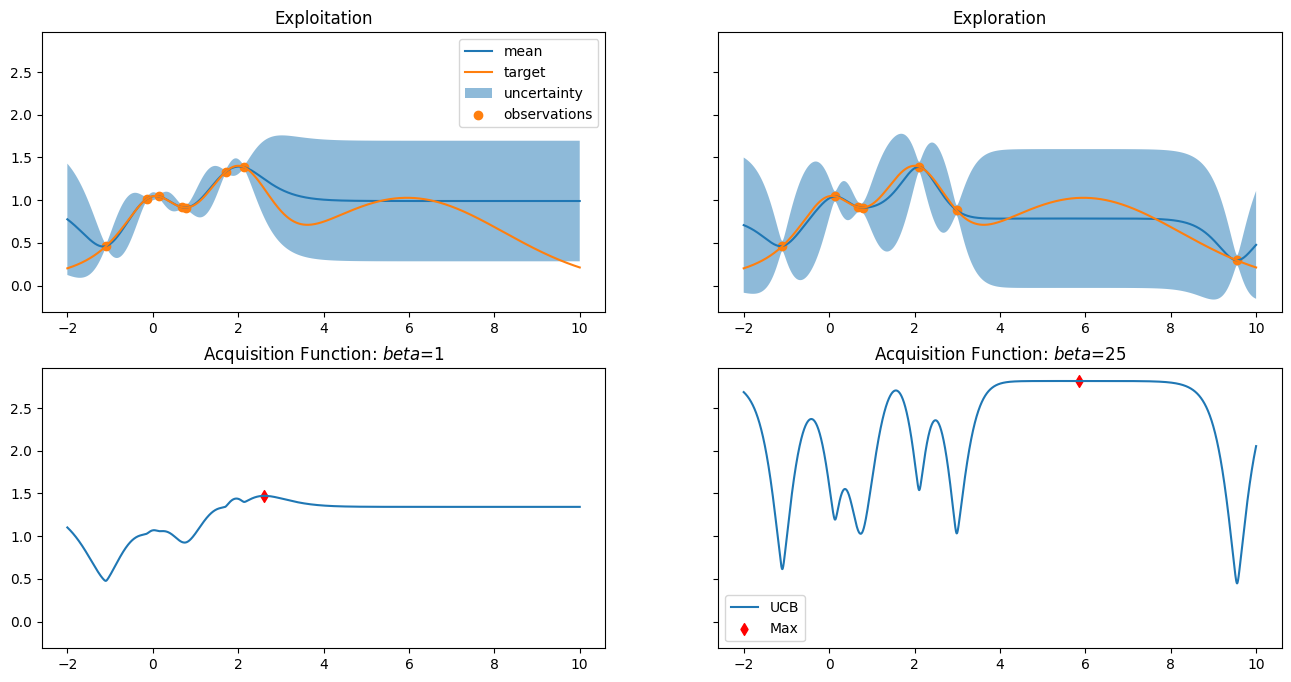

In [15]:
model, mll, train_x, train_obj = step(model, mll, train_x, train_obj, beta=1.)
model_explore, mll_explore, train_x_explore, train_obj_explore = step(model_explore, mll_explore, train_x_explore, train_obj_explore,beta=25.)
plot()

Prior hyperparams lengthscale & noise: 0.6931471824645996, 2.000000476837158
Post hyperparams lengthscale & noise:  0.7955050468444824, 0.00011576779070310295
Prior hyperparams lengthscale & noise: 0.6931471824645996, 2.000000476837158
Post hyperparams lengthscale & noise:  0.5431690812110901, 0.0008722119382582605


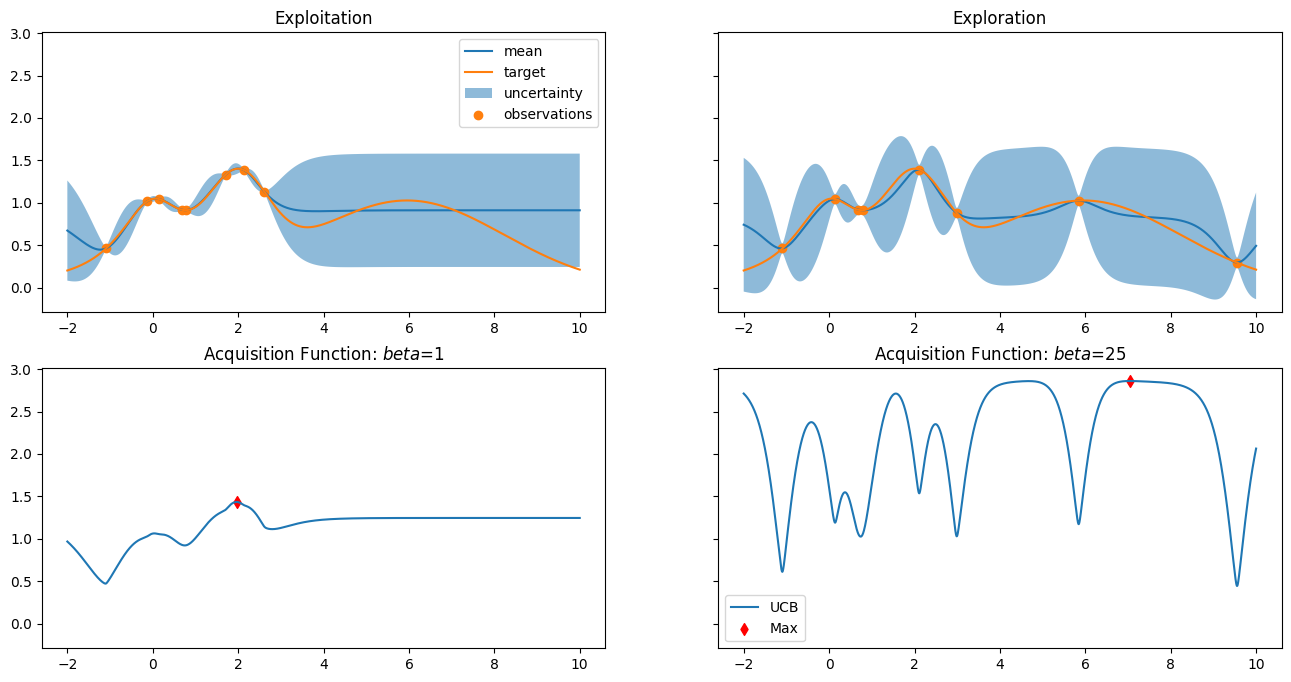

In [16]:
model, mll, train_x, train_obj = step(model, mll, train_x, train_obj, beta=1.)
model_explore, mll_explore, train_x_explore, train_obj_explore = step(model_explore, mll_explore, train_x_explore, train_obj_explore,beta=25.)
plot()

Prior hyperparams lengthscale & noise: 0.6931471824645996, 2.000000476837158
Post hyperparams lengthscale & noise:  0.8857744336128235, 9.999999747378752e-05
Prior hyperparams lengthscale & noise: 0.6931471824645996, 2.000000476837158
Post hyperparams lengthscale & noise:  0.5295915007591248, 0.0005871750181540847


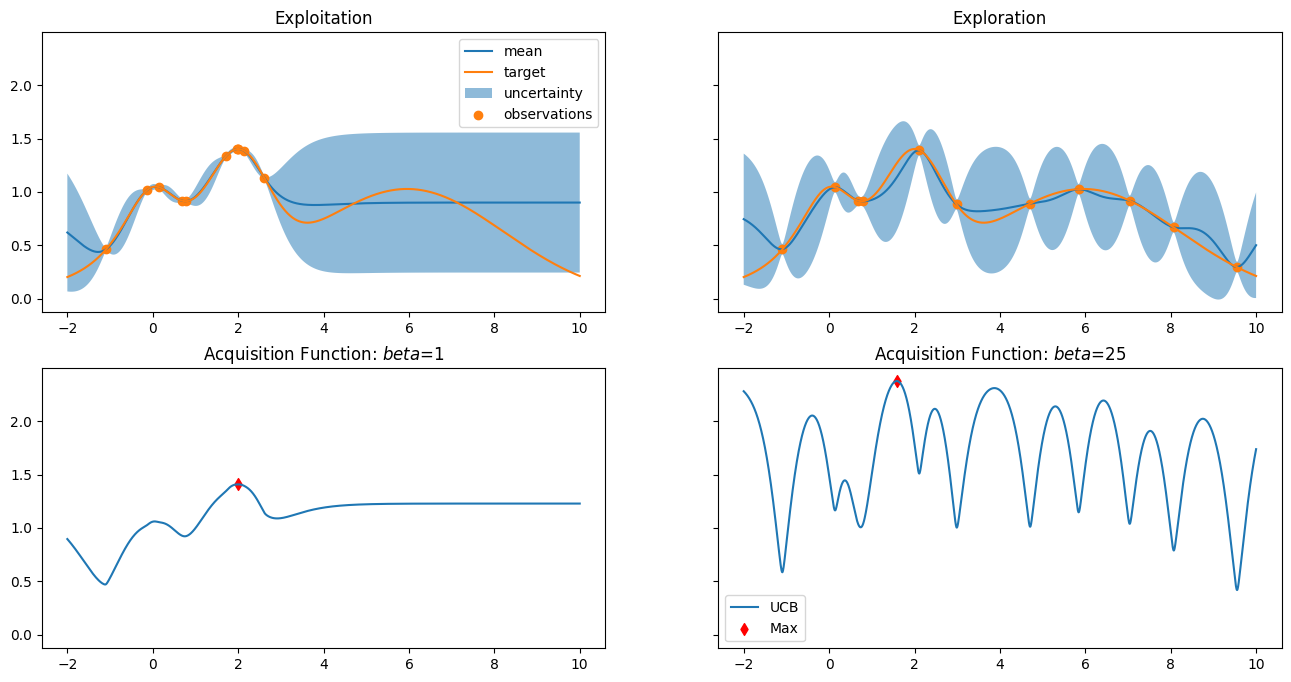

In [19]:
model, mll, train_x, train_obj = step(model, mll, train_x, train_obj, beta=1.)
model_explore, mll_explore, train_x_explore, train_obj_explore = step(model_explore, mll_explore, train_x_explore, train_obj_explore,beta=25.)
plot()

Prior hyperparams lengthscale & noise: 0.6931471824645996, 2.000000476837158
Post hyperparams lengthscale & noise:  0.9091916680335999, 9.999999747378752e-05
Prior hyperparams lengthscale & noise: 0.6931471824645996, 2.000000476837158
Post hyperparams lengthscale & noise:  0.6697551012039185, 0.00022521818755194545


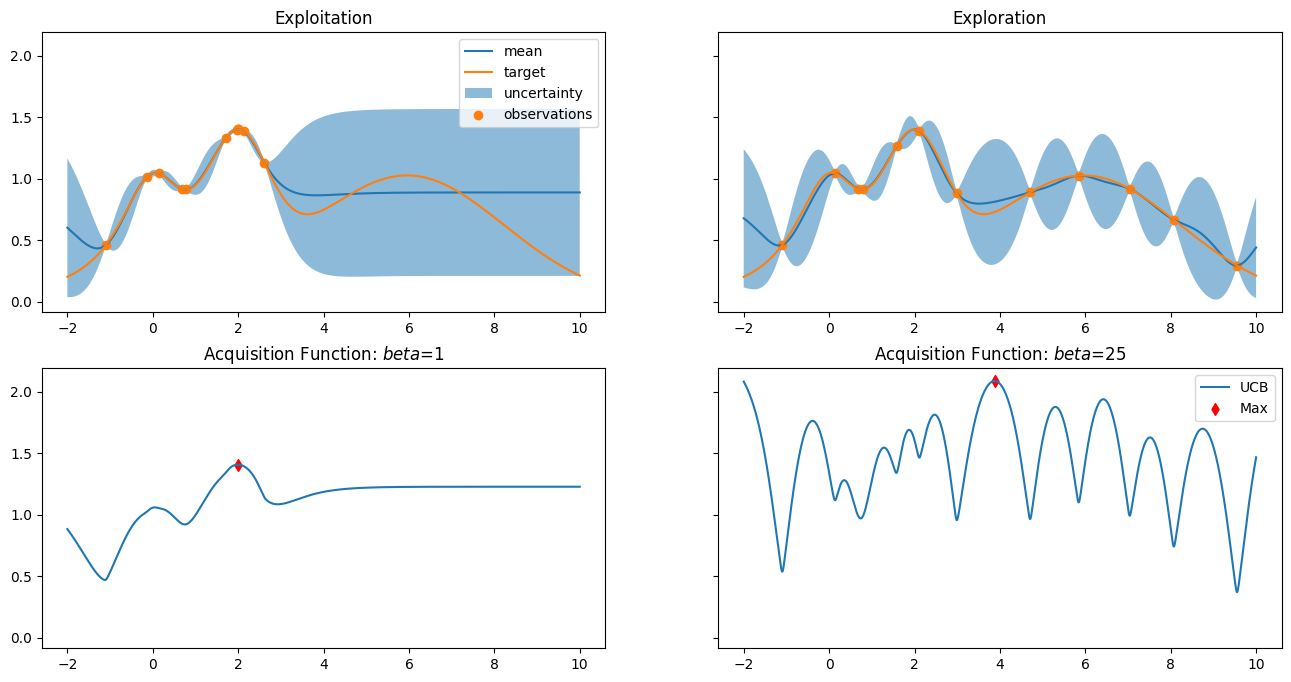

In [20]:
model, mll, train_x, train_obj = step(model, mll, train_x, train_obj, beta=1.)
model_explore, mll_explore, train_x_explore, train_obj_explore = step(model_explore, mll_explore, train_x_explore, train_obj_explore,beta=25.)
plot()

Prior hyperparams lengthscale & noise: 0.6931471824645996, 2.000000476837158
Post hyperparams lengthscale & noise:  0.9084420800209045, 9.999999747378752e-05
Prior hyperparams lengthscale & noise: 0.6931471824645996, 2.000000476837158
Post hyperparams lengthscale & noise:  0.6781761646270752, 0.0002096999087370932


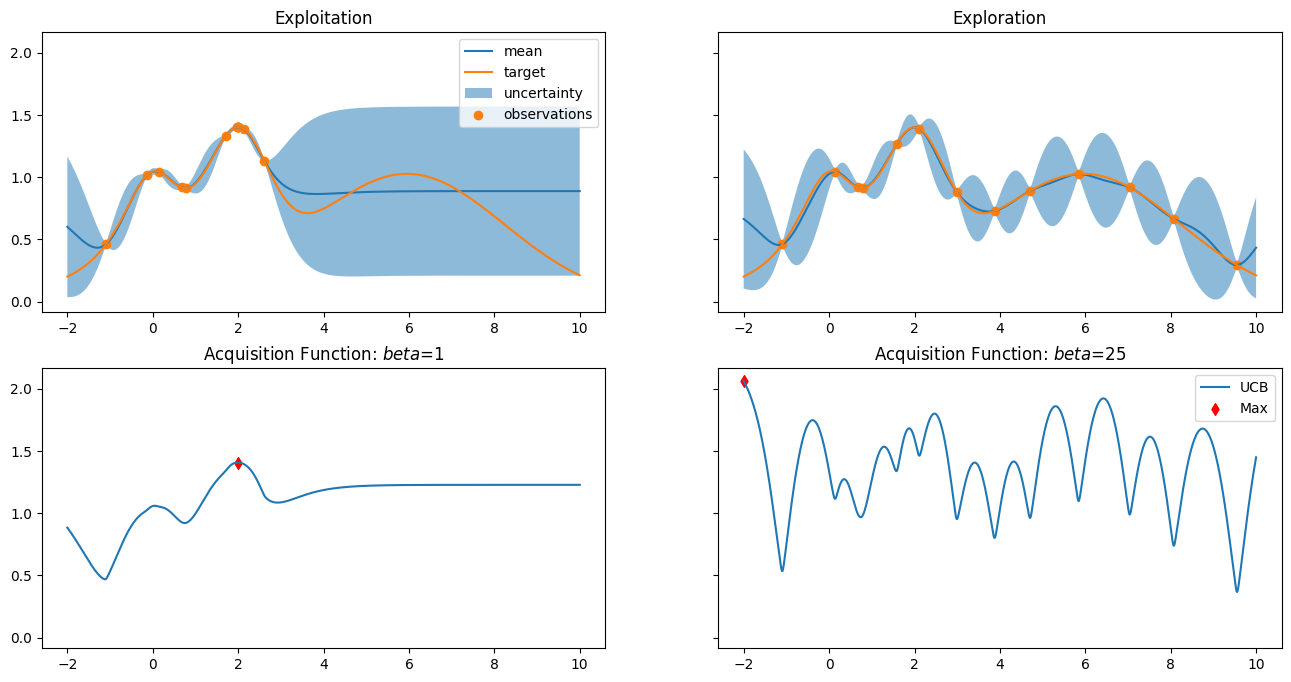

In [21]:
model, mll, train_x, train_obj = step(model, mll, train_x, train_obj, beta=1.)
model_explore, mll_explore, train_x_explore, train_obj_explore = step(model_explore, mll_explore, train_x_explore, train_obj_explore,beta=25.)
plot()

Prior hyperparams lengthscale & noise: 0.6931471824645996, 2.000000476837158
Post hyperparams lengthscale & noise:  0.9086208343505859, 9.999999747378752e-05
Prior hyperparams lengthscale & noise: 0.6931471824645996, 2.000000476837158
Post hyperparams lengthscale & noise:  0.688701868057251, 0.00019950912974309176


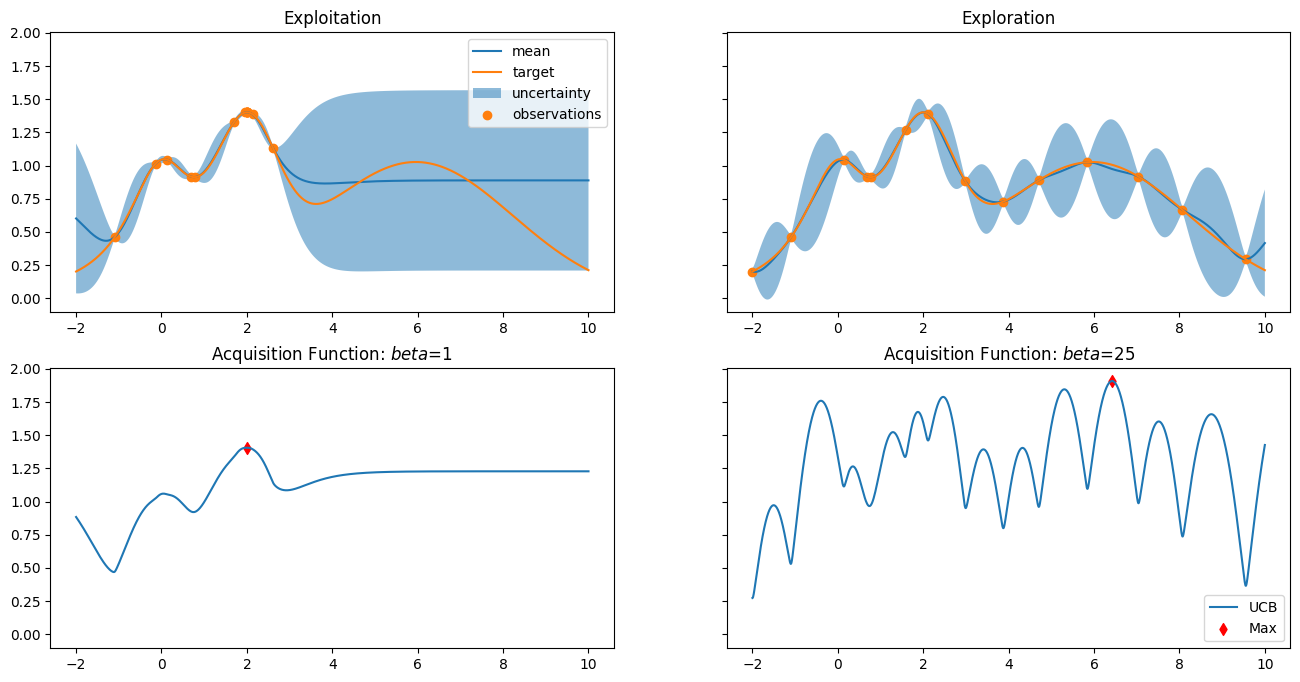

In [22]:
model, mll, train_x, train_obj = step(model, mll, train_x, train_obj, beta=1.)
model_explore, mll_explore, train_x_explore, train_obj_explore = step(model_explore, mll_explore, train_x_explore, train_obj_explore,beta=25.)
plot()

Prior hyperparams lengthscale & noise: 0.6931471824645996, 2.000000476837158
Post hyperparams lengthscale & noise:  0.9090818762779236, 9.999999747378752e-05
Prior hyperparams lengthscale & noise: 0.6931471824645996, 2.000000476837158
Post hyperparams lengthscale & noise:  0.7732868790626526, 0.00012993677228223532


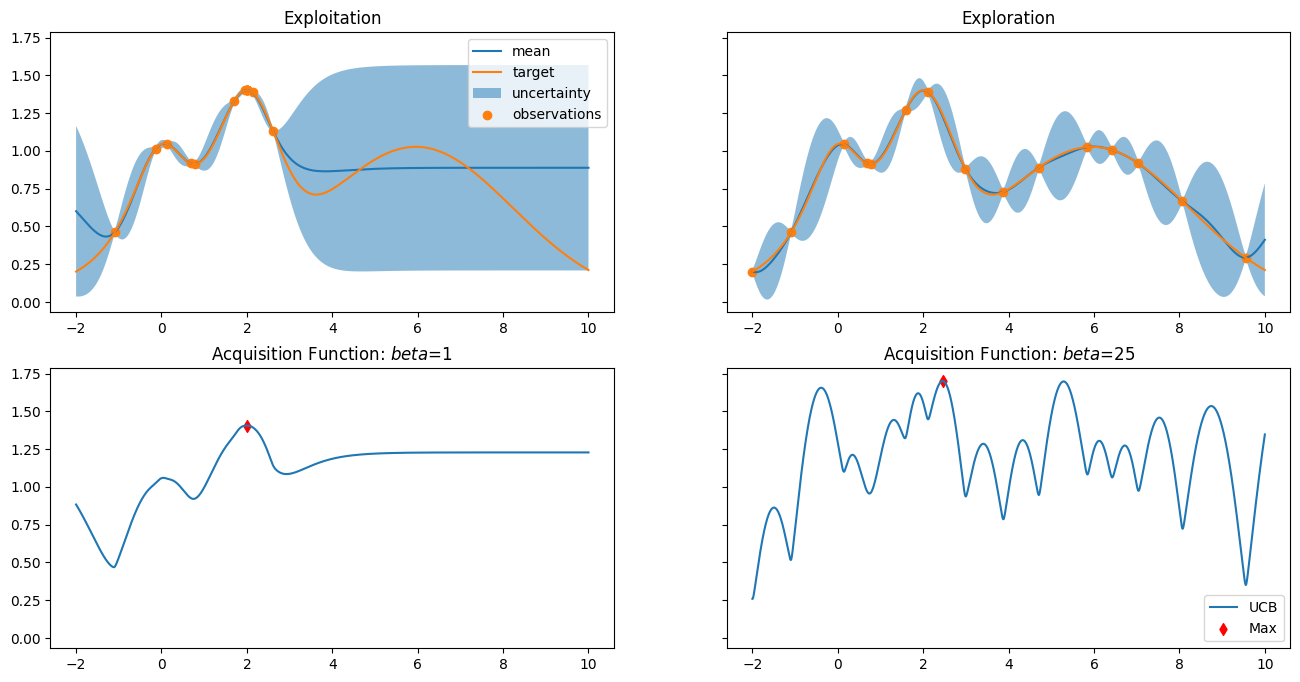

In [23]:
model, mll, train_x, train_obj = step(model, mll, train_x, train_obj, beta=1.)
model_explore, mll_explore, train_x_explore, train_obj_explore = step(model_explore, mll_explore, train_x_explore, train_obj_explore,beta=25.)
plot()

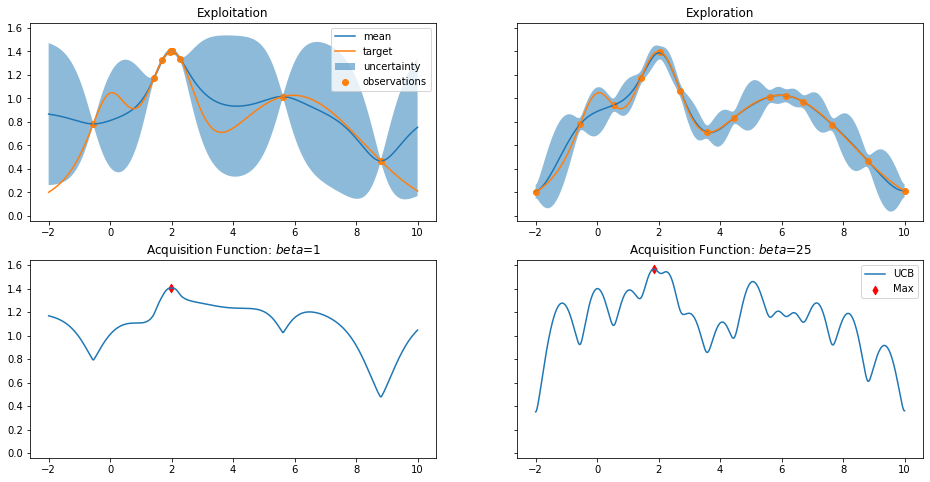

In [19]:
model, mll, train_x, train_obj = step(model, mll, train_x, train_obj, beta=1.)
model_explore, mll_explore, train_x_explore, train_obj_explore = step(model_explore, mll_explore, train_x_explore, train_obj_explore,beta=25.)
plot()

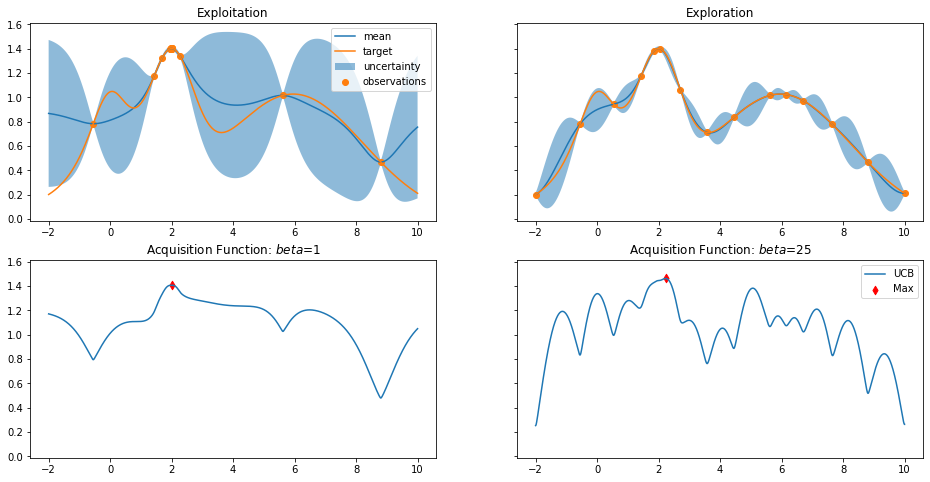

In [20]:
model, mll, train_x, train_obj = step(model, mll, train_x, train_obj, beta=1.)
model_explore, mll_explore, train_x_explore, train_obj_explore = step(model_explore, mll_explore, train_x_explore, train_obj_explore,beta=25.)
plot()

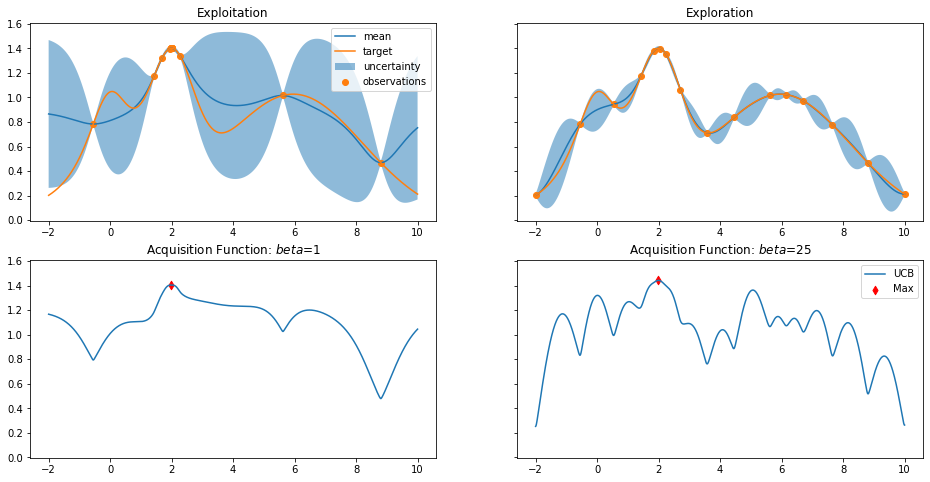

In [21]:
model, mll, train_x, train_obj = step(model, mll, train_x, train_obj, beta=1.)
model_explore, mll_explore, train_x_explore, train_obj_explore = step(model_explore, mll_explore, train_x_explore, train_obj_explore,beta=25.)
plot()

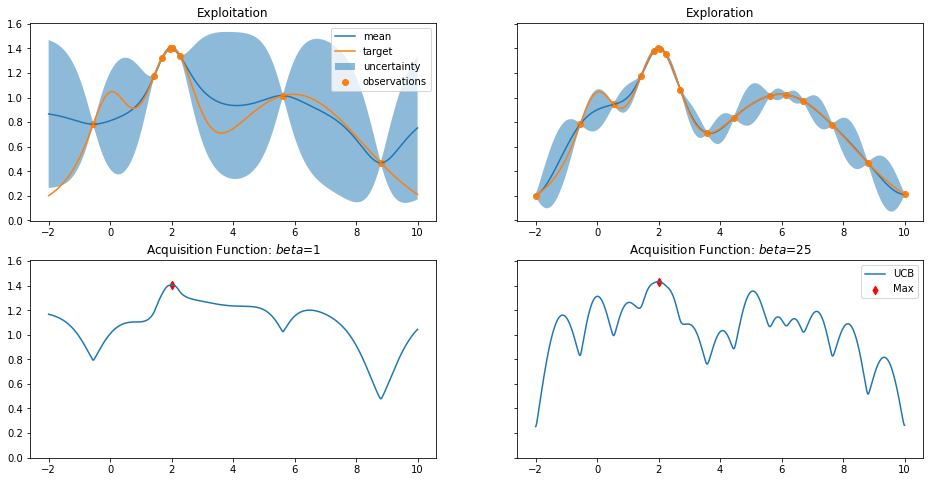

In [22]:
model, mll, train_x, train_obj = step(model, mll, train_x, train_obj, beta=1.)
model_explore, mll_explore, train_x_explore, train_obj_explore = step(model_explore, mll_explore, train_x_explore, train_obj_explore,beta=25.)
plot()

The exploitation model fixates on the maximum of the function, while the exploration model builds a more complete surrogate model. They both are able to learn the maximum. But, with poor random initialization, the exploitation model will not be able to learn the global maximum.